# Final project - London travel recommendation
### Applied Data Science Capstone by IBM/Coursera

#### Introduction:
This notebook will contain code and description where needed for the final capstone project. 
In this project, we will use datasets for the city of Sydney, Australia and London, United Kingdom.
Since detailed information about all neighborhoods in Sydney, Australia was not available, a subset was used and data manually cleaned.

The purpose of this project is to 
-  Try and recommend a traveler from Sydney, Australia a visit to London, United Kingdom given the diversity
-  Which neighbourhood is likely to be most similar to ones he finds back home, based on type of venues.
-  For a traveler interested in trying new restaurants and cuisines, make recommendations on where to visit 

This would be very useful to a person new to a city, who might not know much about the layout and history of the city, beyond the usual tourist spots.

It would also be of interest to an intrepid travel willing to try new things.


#### Data sources
London, UK - 

https://en.wikipedia.org/wiki/List_of_areas_of_London


Sydney, UK -

https://en.wikipedia.org/wiki/City_of_Sydney

https://raw.githubusercontent.com/sbalanchickoo/datasets/master/coursera/SydneyLocalities.csv

#### Structure: 

This notebook is comprised of three parts: 
  - London data
  - Sydney data
  - Recommendations

<a class="anchor" id="toc"></a>
## Table of contents:
* [Part 1 - London neighborhood segmentation](#london)
* [Part 2 - Sydney localities](#sydney)
* [Part 3 - Analysis](#analysis)

In [1]:
%config Completer.use_jedi = False

In [2]:
#!conda install -c conda-forge geocoder -y
#!conda install lxml -y
#!conda install -c conda-forge/label/gcc7 folium -y
#!conda install matplotlib

In [3]:
import pandas as pd
import numpy as np
import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import cm
import matplotlib.colors as colors
import json

# import k-means from clustering stage
from sklearn.cluster import KMeans
import copy
import folium # map rendering library

<a class="anchor" id="london"></a>
## Part 1 - London
[Back to top](#toc)

### London - Download and clean data

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
table_MN = pd.read_html(url, match='borough')
len(table_MN)
df = table_MN[0]
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [5]:
df_london = copy.deepcopy(df)
df_london.columns = ['Location', 'Borough', 'Town', 'Postcode', 'Dial', 'Grid']
cols = ['Borough', 'Town', 'Postcode']
df_london = df_london[cols]
df_london.head()

,Borough,Town,Postcode
0,"Bexley, Greenwich [7]",LONDON,SE2
1,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4"
2,Croydon[8],CROYDON,CR0
3,Croydon[8],CROYDON,CR0
4,Bexley,"BEXLEY, SIDCUP","DA5, DA14"


In [6]:
# remove counts in borough names
df_london['Borough'] = df_london['Borough'].str.split('[').str[0]
df_london['Borough'] = df_london['Borough'].str.strip()

# only keep rows where town is London
df_london = df_london.loc[df_london['Town'] == 'LONDON', :]
cols = ['Borough', 'Postcode']
df_london = df_london[cols]

# remove rows where borough contains commas, for simplicity
idx = df_london.loc[df_london['Borough'].str.contains(','), :].index
df_london.drop(idx, inplace=True)
df_london.drop_duplicates()

df_london.head()

,Borough,Postcode
6,City,EC3
7,Westminster,WC2
9,Bromley,SE20
10,Islington,"EC1, N1"
12,Islington,N19


In [7]:
# split rows with mutiple post codes into individual ones
df_mult = df_london.loc[df_london['Postcode'].str.contains(','), :]
idx = list(df_mult.index)
df_new = pd.DataFrame(columns=['Borough', 'Postcode'])
for i in idx:
    postcodes = df_mult.loc[i, 'Postcode'].split(',')
    for p in postcodes:
        b = df_mult.loc[i, 'Borough']
        new_row = pd.DataFrame([[b, p.strip()]], columns=['Borough', 'Postcode'])
        df_new = df_new.append(new_row)

df_london.drop(idx, inplace=True)
df_london = df_london.append(df_new)
df_london.reset_index(inplace=True, drop=True)

df_london.head()

,Borough,Postcode
0,City,EC3
1,Westminster,WC2
2,Bromley,SE20
3,Islington,N19
4,Wandsworth,SW12


### Use geopy to get latitude and longitude

In [8]:
geolocator = Nominatim(user_agent="my-app")

for idx in list(df_london.index):
    ctr = 0
    # loop until you get the coordinates
    postal_code = df_london.loc[idx, 'Postcode']
    address = postal_code + ', London, UK'
    # initialize your variable to None
    location = None
    while(location is None) and ctr  < 2:
        location = geolocator.geocode(address)
        ctr += 1
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
        df_london.loc[idx, 'Latitude'] = latitude
        df_london.loc[idx, 'Longitude'] = longitude

df_london.head()

,Borough,Postcode,Latitude,Longitude
0,City,EC3,51.511333,-0.081960
1,Westminster,WC2,51.511740,-0.122472
2,Bromley,SE20,51.410011,-0.058192
3,Islington,N19,51.567824,-0.138827
4,Wandsworth,SW12,51.443800,-0.152629


### Visualize the post codes

In [9]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df_london['Latitude'], df_london['Longitude'], df_london['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7
    ).add_to(map_london)  
    
map_london

In [10]:
import webbrowser
output_file = "map2.html"
map_london.save(output_file)
webbrowser.open(output_file, new=2)  # open in new tab

True

### Explore using foursquare data

In [11]:
# @hidden_cell
# Credentials
with open('../credentials/foursquare.json') as f:
    data = json.load(f)

CLIENT_ID = data['CLIENT_ID']
CLIENT_SECRET = data['CLIENT_SECRET']
VERSION = data['VERSION']
LIMIT = 100 # A default Foursquare API limit value

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Create a function to get nearby venues and categories for all the post codes in London

In [21]:
def getNearbyVenues(boroughs, postcodes, latitudes, longitudes, radius):
    
    venues_list=[]
    for borough, postcode, lat, lng in zip(boroughs, postcodes, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                             'Postcode', 
                             'Postcode Latitude', 
                             'Postcode Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [26]:
# url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#             CLIENT_ID, 
#             CLIENT_SECRET, 
#             VERSION, 
#             '51.511333', 
#             '-0.081960', 
#             250, 
#             100)
            
# results = requests.get(url).json()["response"]
# results['groups'][0]['items']

In [25]:
london_venues = getNearbyVenues(df_london['Borough'],
                                df_london['Postcode'], 
                                df_london['Latitude'], 
                                df_london['Longitude'],
                                radius=200)
print('There are {} unique categories.'.format(len(london_venues['Venue Category'].unique())))
london_venues.head()

There are 176 unique categories.


,Borough,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,City,EC3,51.511333,-0.08196,St Dunstan in the East Garden,51.509716,-0.082354,Garden
1,City,EC3,51.511333,-0.08196,BrewDog Tower Hill,51.509948,-0.080977,Beer Bar
2,City,EC3,51.511333,-0.08196,Sky Garden,51.511168,-0.083625,Scenic Lookout
3,City,EC3,51.511333,-0.08196,Curators Coffee Studio,51.512085,-0.082568,Coffee Shop
4,City,EC3,51.511333,-0.08196,Blacklock City,51.510837,-0.084173,Steakhouse


### Analyse each post code

In [27]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = london_venues['Borough']
london_onehot['Postcode'] = london_venues['Postcode'] 

# move neighborhood column to the first column
cols = list(london_onehot.columns)
cols.remove('Borough')
cols.remove('Postcode')
new_cols = ['Borough', 'Postcode'] + cols
london_onehot = london_onehot[new_cols]

london_onehot.head()

,Borough,Postcode,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,City,EC3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,City,EC3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,City,EC3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,City,EC3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,City,EC3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

This is the percent of each category of venues, in each neighborhood

In [28]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped

,Borough,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Austrian Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Barnet,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bexley,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Brent,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.137255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bromley,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Camden,0.0,0.009390,0.000000,0.004695,0.000000,0.000000,0.000000,0.000000,0.004695,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009390,0.009390,0.004695,0.000000
5,City,0.0,0.000000,0.000000,0.000000,0.013889,0.027778,0.000000,0.000000,0.000000,...,0.000000,0.013889,0.000000,0.000000,0.013889,0.000000,0.027778,0.000000,0.000000,0.000000
6,Croydon,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Ealing,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Enfield,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.076923,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Greenwich,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000


### Sort by most common type of venue

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
london_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
london_neighborhoods_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    london_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

london_neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,Park,Hotel,Café,Playground,Trail,Health & Beauty Service,Grocery Store,Fish & Chips Shop,Pizza Place,Bed & Breakfast
1,Bexley,Café,African Restaurant,Portuguese Restaurant,Museum,Music Store,Nail Salon,Nightclub,Office,Opera House,Optical Shop
2,Brent,Bus Stop,Gym / Fitness Center,Pub,Train Station,Grocery Store,Flower Shop,Convenience Store,Indian Restaurant,Hotel,Music Store
3,Bromley,Pub,Supermarket,Fast Food Restaurant,Chinese Restaurant,Park,Optical Shop,Museum,Music Store,Nail Salon,Nightclub
4,Camden,Park,Garden,Theater,Bus Stop,Café,Convenience Store,Grocery Store,Coffee Shop,Bakery,Italian Restaurant


<a class="anchor" id="sydney"></a>
## Part 2 - Sydney
[Back to top](#toc)

### Sydney - Download and clean data

In [31]:
url = 'https://raw.githubusercontent.com/sbalanchickoo/datasets/master/coursera/SydneyLocalities.csv'
df_sydney = pd.read_csv(url)
df_sydney

,Locality,Latitude,Longitude,Source
0,Broadway,-33.8839,151.1939,https://latitude.to/articles-by-country/au/aus...
1,Central,-33.8849,151.1939,https://en.wikipedia.org/wiki/Central_railway_...
2,Central Park,-33.8846,151.2006,https://www.google.com/search?sxsrf=ALeKk02y_-...
3,Chinatown,-33.8796,151.2059,https://www.google.com/search?sxsrf=ALeKk010V9...
4,Circular Quay,-33.8611,151.2111,https://en.wikipedia.org/wiki/Circular_Quay
5,Darling Harbour,-33.8796,151.2009,https://www.google.com/search?sxsrf=ALeKk01Uuk...
6,The Domain,-33.8683,151.2147,"https://en.wikipedia.org/wiki/The_Domain,_Sydney"
7,East Sydney,NaN,NaN,Gap
8,Garden Island,-33.8589,151.2294,https://www.google.com/search?sxsrf=ALeKk02avt...
9,Goat Island,-33.8522,151.1966,https://en.wikipedia.org/wiki/Goat_Island_(Por...


In [32]:
cols = ['Locality', 'Latitude', 'Longitude']
df_sydney = df_sydney[cols]
df_sydney = df_sydney.loc[df_sydney['Latitude'].notnull(), :]
df_sydney.reset_index(inplace=True, drop=True)
df_sydney

,Locality,Latitude,Longitude
0,Broadway,-33.8839,151.1939
1,Central,-33.8849,151.1939
2,Central Park,-33.8846,151.2006
3,Chinatown,-33.8796,151.2059
4,Circular Quay,-33.8611,151.2111
5,Darling Harbour,-33.8796,151.2009
6,The Domain,-33.8683,151.2147
7,Garden Island,-33.8589,151.2294
8,Goat Island,-33.8522,151.1966
9,Green Square,-33.9065,151.2035


### Visualize the localities

In [33]:
df_avg = np.mean(df_sydney.loc[:, ['Latitude', 'Longitude']])

map_sydney = folium.Map(location=[df_avg[0], df_avg[1]], zoom_start=13)

# add markers to map
for lat, lng, locality in zip(df_sydney['Latitude'], df_sydney['Longitude'], df_sydney['Locality']):
    label = '{}'.format(locality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7
    ).add_to(map_sydney)  
    
map_sydney

### Get nearby venues

In [34]:
sydney_venues = getNearbyVenues(df_sydney['Locality'],
                                df_sydney['Locality'], 
                                df_sydney['Latitude'], 
                                df_sydney['Longitude'],
                                radius=200)
print('There are {} unique categories.'.format(len(sydney_venues['Venue Category'].unique())))
sydney_venues.head()

There are 102 unique categories.


,Borough,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Broadway,Broadway,-33.8839,151.1939,Staves Brewery,-33.884055,151.194281,Brewery
1,Broadway,Broadway,-33.8839,151.1939,Harris Farm Markets,-33.883650,151.193760,Fruit & Vegetable Store
2,Broadway,Broadway,-33.8839,151.1939,Badde Manors,-33.883651,151.191968,Vegetarian / Vegan Restaurant
3,Broadway,Broadway,-33.8839,151.1939,At Home Thai,-33.883883,151.192314,Thai Restaurant
4,Broadway,Broadway,-33.8839,151.1939,Apple Broadway,-33.883579,151.194366,Electronics Store


In [35]:
# one hot encoding
sydney_onehot = pd.get_dummies(sydney_venues[['Venue Category']], prefix="", prefix_sep="")

# # add neighborhood column back to dataframe
sydney_onehot['Locality'] = sydney_venues['Borough']

# move neighborhood column to the first column
cols = list(sydney_onehot.columns)
cols.remove('Locality')
new_cols = ['Locality'] + cols
sydney_onehot = sydney_onehot[new_cols]

sydney_onehot.head()

,Locality,Arcade,Art Gallery,Asian Restaurant,Australian Restaurant,Bakery,Bar,Basketball Court,Big Box Store,Bistro,...,Thai Restaurant,Theater,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,Broadway,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Broadway,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Broadway,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Broadway,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Broadway,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
sydney_grouped = sydney_onehot.groupby('Locality').mean().reset_index()
sydney_grouped

,Locality,Arcade,Art Gallery,Asian Restaurant,Australian Restaurant,Bakery,Bar,Basketball Court,Big Box Store,Bistro,...,Thai Restaurant,Theater,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar
0,Broadway,0.021739,0.000000,0.000000,0.000000,0.000000,0.043478,0.021739,0.021739,0.000000,...,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.021739,0.000000,0.000000
1,Central,0.023810,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.023810,0.000000,...,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000
2,Central Park,0.000000,0.030303,0.000000,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,...,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303
3,Chinatown,0.000000,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,...,0.178571,0.035714,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000
4,Circular Quay,0.000000,0.000000,0.000000,0.027778,0.000000,0.083333,0.000000,0.000000,0.027778,...,0.027778,0.000000,0.027778,0.027778,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000
5,Darling Harbour,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000
6,Garden Island,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Goat Island,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Green Square,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Kings Cross,0.000000,0.000000,0.021277,0.042553,0.000000,0.042553,0.000000,0.000000,0.000000,...,0.042553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277


In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Locality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sydney_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
sydney_neighborhoods_venues_sorted['Locality'] = sydney_grouped['Locality']

for ind in np.arange(sydney_grouped.shape[0]):
    sydney_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sydney_grouped.iloc[ind, :], num_top_venues)

sydney_neighborhoods_venues_sorted.head()

,Locality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Broadway,Café,Coffee Shop,Burger Joint,Supermarket,Bar,Electronics Store,Thai Restaurant,Shopping Mall,Discount Store,Dumpling Restaurant
1,Central,Coffee Shop,Bar,Electronics Store,Supermarket,Café,Burger Joint,Thai Restaurant,Arcade,Discount Store,Kebab Restaurant
2,Central Park,Café,Coffee Shop,Ice Cream Shop,Hotel,Cocktail Bar,Discount Store,Supermarket,Street Food Gathering,Steakhouse,Dessert Shop
3,Chinatown,Thai Restaurant,Japanese Restaurant,Sandwich Place,Chinese Restaurant,Massage Studio,Art Gallery,Pastry Shop,Ice Cream Shop,Hotpot Restaurant,Hotel
4,Circular Quay,Café,Ice Cream Shop,Bar,Mexican Restaurant,Indian Restaurant,Sandwich Place,Steakhouse,Italian Restaurant,Restaurant,Creperie


In [38]:
london_neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,Park,Hotel,Café,Playground,Trail,Health & Beauty Service,Grocery Store,Fish & Chips Shop,Pizza Place,Bed & Breakfast
1,Bexley,Café,African Restaurant,Portuguese Restaurant,Museum,Music Store,Nail Salon,Nightclub,Office,Opera House,Optical Shop
2,Brent,Bus Stop,Gym / Fitness Center,Pub,Train Station,Grocery Store,Flower Shop,Convenience Store,Indian Restaurant,Hotel,Music Store
3,Bromley,Pub,Supermarket,Fast Food Restaurant,Chinese Restaurant,Park,Optical Shop,Museum,Music Store,Nail Salon,Nightclub
4,Camden,Park,Garden,Theater,Bus Stop,Café,Convenience Store,Grocery Store,Coffee Shop,Bakery,Italian Restaurant


<a class="anchor" id="analysis"></a>
## Part 3 - Analysis
[Back to top](#toc)

### Unique venue categories

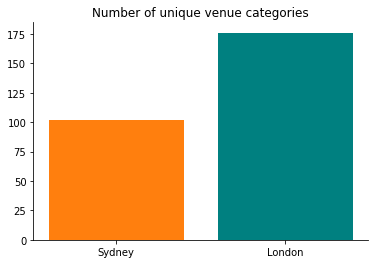

In [39]:
sydney_unique = sydney_venues['Venue Category'].nunique()
london_unique = london_venues['Venue Category'].nunique()

labels = ['Sydney', 'London']
vals = [sydney_unique, london_unique]
colors = ['tab:orange', 'teal']
fig = plt.figure()
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Number of unique venue categories')

ax.bar(x = labels, height = vals, color=colors);

### Restaurants

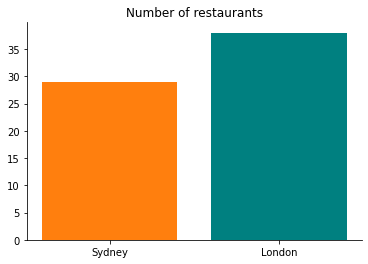

In [40]:
sydney_restaurants = sydney_venues.loc[sydney_venues['Venue Category'].str.contains('Restaurant'), 'Venue Category'].nunique()
london_restaurants = london_venues.loc[london_venues['Venue Category'].str.contains('Restaurant'), 'Venue Category'].nunique()

labels = ['Sydney', 'London']
vals = [sydney_restaurants, london_restaurants]
colors = ['tab:orange', 'teal']
fig = plt.figure()
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Number of restaurants')

ax.bar(x = labels, height = vals, color=colors);

### Diversity of neighborhood

In [41]:
# get only the venues
london_venues_only = copy.deepcopy(london_venues.loc[:, ['Borough', 'Venue Category']])
sydney_venues_only = copy.deepcopy(sydney_venues.loc[:, ['Borough', 'Venue Category']])

# get the most common venues
london_venues_most_common = copy.deepcopy(london_neighborhoods_venues_sorted)
sydney_venues_most_common = copy.deepcopy(sydney_neighborhoods_venues_sorted)

In [42]:
# isolate boroughs / localities within top 10, with at least 5 venues  - London
london_top10_atl5 = pd.DataFrame(columns=['Borough', 'Venue Category'])

for i in range(len(london_venues_most_common.index)):
    borough = london_venues_most_common.iloc[i, 0]
    venues = list(london_venues_most_common.iloc[i, 1:])
    df_borough = pd.DataFrame([borough, k] for k in venues)
    df_borough.columns = ['Borough', 'Venue Category']
    london_top10_atl5 = pd.concat([london_top10_atl5, df_borough])

# merge dfs
london_top10_atl5 = pd.merge(london_venues_only, london_top10_atl5, how='inner', )

# # only consider boroughs with at least 5 errors to remove areas with insufficient data
london_top10_atl5_counts = london_top10_atl5.groupby(['Borough', 'Venue Category']).size().reset_index(name='counts')
london_top10_atl5_stats = london_top10_atl5_counts.groupby(['Borough']).agg({'counts': ['mean', 'sum']})
london_top10_atl5_stats.columns = london_top10_atl5_stats.columns.get_level_values(1)
london_top10_atl5_stats = london_top10_atl5_stats.loc[london_top10_atl5_stats['sum'] >= 5, :].reset_index()

# merge to filter out dfs
london_top10_atl5 = pd.merge(london_top10_atl5, london_top10_atl5_stats, how='inner', )
london_top10_atl5_counts = pd.merge(london_top10_atl5_counts, london_top10_atl5_stats, how='inner', )

cols = ['Borough', 'Venue Category']
london_top10_atl5 = london_top10_atl5[cols]

cols = ['Borough', 'Venue Category', 'counts', 'sum']
london_top10_atl5_counts = london_top10_atl5_counts[cols]


In [43]:
# isolate boroughs / localities within top 10, with at least 5 venues  - Sydney
sydney_top10_atl5 = pd.DataFrame(columns=['Borough', 'Venue Category'])

for i in range(len(sydney_venues_most_common.index)):
    borough = sydney_venues_most_common.iloc[i, 0]
    venues = list(sydney_venues_most_common.iloc[i, 1:])
    df_borough = pd.DataFrame([borough, k] for k in venues)
    df_borough.columns = ['Borough', 'Venue Category']
    sydney_top10_atl5 = pd.concat([sydney_top10_atl5, df_borough])

# merge dfs
sydney_top10_atl5 = pd.merge(sydney_venues_only, sydney_top10_atl5, how='inner', )

# # only consider boroughs with at least 5 errors to remove areas with insufficient data
sydney_top10_atl5_counts = sydney_top10_atl5.groupby(['Borough', 'Venue Category']).size().reset_index(name='counts')
sydney_top10_atl5_stats = sydney_top10_atl5_counts.groupby(['Borough']).agg({'counts': ['mean', 'sum']})
sydney_top10_atl5_stats.columns = sydney_top10_atl5_stats.columns.get_level_values(1)
sydney_top10_atl5_stats = sydney_top10_atl5_stats.loc[sydney_top10_atl5_stats['sum'] >= 5, :].reset_index()

# merge to filter out dfs
sydney_top10_atl5 = pd.merge(sydney_top10_atl5, sydney_top10_atl5_stats, how='inner', )
sydney_top10_atl5_counts = pd.merge(sydney_top10_atl5_counts, sydney_top10_atl5_stats, how='inner', )

cols = ['Borough', 'Venue Category']
sydney_top10_atl5 = sydney_top10_atl5[cols]

cols = ['Borough', 'Venue Category', 'counts', 'sum']
sydney_top10_atl5_counts = sydney_top10_atl5_counts[cols]


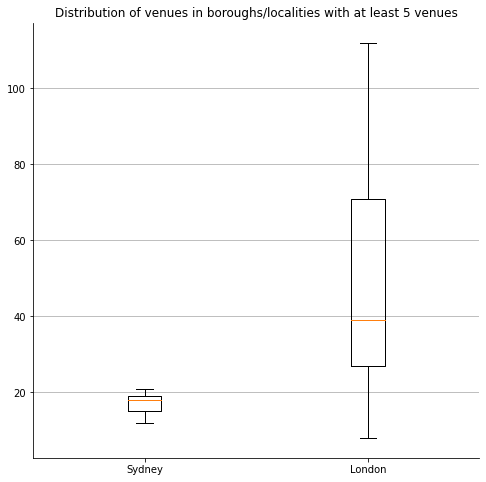

In [44]:
labels = ['Sydney', 'London']
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Distribution of venues in boroughs/localities with at least 5 venues')
ax.grid(axis='y')

ax.boxplot([sydney_top10_atl5_counts.loc[:, 'sum'], london_top10_atl5_counts.loc[:, 'sum']]
           , labels=labels
           , showfliers=False
          );

### Restaurants

In [45]:
sydney_top10_atl5_rest = sydney_top10_atl5.loc[sydney_top10_atl5['Venue Category'].str.contains('Restaurant'), :]
london_top10_atl5_rest = london_top10_atl5.loc[london_top10_atl5['Venue Category'].str.contains('Restaurant'), :]

In [46]:
london_top10_atl5_rest_counts = london_top10_atl5_rest.groupby(['Borough']).size().reset_index(name='counts')
sydney_top10_atl5_rest_counts = sydney_top10_atl5_rest.groupby(['Borough']).size().reset_index(name='counts')

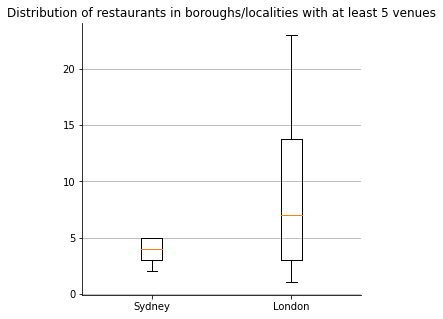

In [47]:
labels = ['Sydney', 'London']
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Distribution of restaurants in boroughs/localities with at least 5 venues')
ax.grid(axis='y')

ax.boxplot([sydney_top10_atl5_rest_counts.loc[:, 'counts'], london_top10_atl5_rest_counts.loc[:, 'counts']]
           , labels=labels
           , showfliers=False
          );

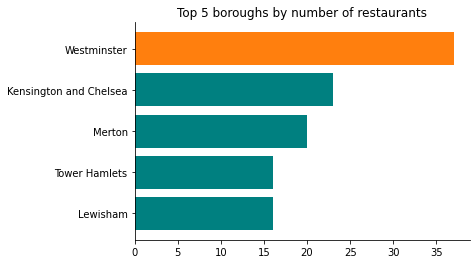

In [48]:
london_top10_atl5_rest_counts_sorted = (london_top10_atl5_rest_counts.sort_values('counts', ascending=False)
                                        .reset_index(drop=True))
london_top10_atl5_rest_counts_sorted = london_top10_atl5_rest_counts_sorted.iloc[0:5, :]
london_top10_atl5_rest_counts_sorted
labels = list(london_top10_atl5_rest_counts_sorted['Borough'])

fig = plt.figure()
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
colors = ['tab:orange', 'teal', 'teal', 'teal', 'teal']
ax.set_title('Top 5 boroughs by number of restaurants')
y_pos = np.arange(len(list(london_top10_atl5_rest_counts_sorted['Borough'])))
ax.invert_yaxis()

ax.barh(labels, london_top10_atl5_rest_counts_sorted['counts'], color=colors);


In [49]:
map_london_rest = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(df_london['Latitude'], df_london['Longitude'], df_london['Borough']):
    if borough in labels:
        label = '{}'.format(borough)
        label = folium.Popup(label, parse_html=True)
        if borough == 'Westminster':
            color = '#cc4131'
        else:
            color = '#3186cc'
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='color',
            fill=True,
            fill_color=color,
            fill_opacity=0.7
        ).add_to(map_london_rest)  
    
map_london_rest